In [1]:
import pandas as pd
import unicodedata
import jieba
import jieba.posseg as pseg
jieba.enable_paddle()
%matplotlib inline

Paddle enabled successfully......


In [2]:
df = pd.read_csv('train.csv', dtype=str)

In [3]:
df.head()

,category,query1,query2,label
0,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血是什么原因？,1
1,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后为什么会咯血？,1
2,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血，应该怎么处理？,0
3,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血，需要就医吗？,0
4,咳血,"剧烈运动后咯血,是怎么了?",剧烈运动后咯血，是否很严重？,0


In [4]:
df[df.label.isnull()]

,category,query1,query2,label
350,支原体肺炎,小儿支原体肺炎怎样能彻底治愈,小儿支原体肺炎如何根治？,NaN
351,支原体肺炎,小儿支原体肺炎怎样能彻底治愈,小儿支原体肺炎怎样可以彻底治好？,NaN
352,支原体肺炎,小儿支原体肺炎怎样能彻底治愈,小孩支原体肺炎多久能痊愈？,NaN
353,支原体肺炎,小儿支原体肺炎怎样能彻底治愈,如何诊断小儿支原体肺炎？,NaN
354,支原体肺炎,小儿支原体肺炎怎样能彻底治愈,小儿支原体肺炎有哪些病症？,NaN
8052,哮喘,请问，怎么可以治疗哮喘病,哮喘病发吃什么有效？,NaN


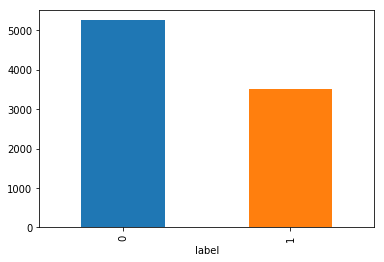

In [5]:
df.groupby("label")['query1'].count().plot.bar()

In [6]:
a = 100
for i in range(a,a+10):
    print(df.query1[i])
    print(df.query2[i])
    print()

请问百令胶囊一天吃多少？
请问百令胶囊一天需要服用多少呢？

请问百令胶囊一天吃多少？
请问百令胶囊是一日三次吗？

请问百令胶囊一天吃多少？
请问百令胶囊的效果怎么样？

请问百令胶囊一天吃多少？
请问百令胶囊是苦的还是咸的？

请问百令胶囊一天吃多少？
请问百令胶囊的注意事项是什么？

康尔佳益肺止咳胶囊发烧了是不是副作用？
康尔佳益肺止咳胶囊会不会产生发烧的副作用？

康尔佳益肺止咳胶囊发烧了是不是副作用？
康尔佳益肺止咳胶囊是不是会有发烧的不良反应？

康尔佳益肺止咳胶囊发烧了是不是副作用？
康尔佳益肺止咳胶囊有什么作用？

康尔佳益肺止咳胶囊发烧了是不是副作用？
康尔佳益肺止咳胶囊可以治疗发烧吗？

康尔佳益肺止咳胶囊发烧了是不是副作用？
康尔佳益肺止咳胶囊怎么服用？



In [7]:
def words(s):
    s = unicodedata.normalize('NFKC', s).lower()
    return [word for word, pos in pseg.cut(s, use_paddle=True) if pos != 'w']

def process1(row):
    w1 = words(row['query1'])
    w2 = words(row['query2'])
    q1 = set(w1)
    q2 = set(w2)
    return ' '.join([x for x in w1 if x in q1-q2])

def process2(row):
    w1 = words(row['query1'])
    w2 = words(row['query2'])
    q1 = set(w1)
    q2 = set(w2)
    return ' '.join([x for x in w2 if x in q2-q1])

In [8]:
df['query1seg'] = df.apply(process1, axis=1)
df['query2seg'] = df.apply(process2, axis=1)

In [9]:
a = 100
for i in range(a,a+10):
    print(df.query1seg[i])
    print(df.query2seg[i])
    print()

吃
需要 服用 呢

一天 吃 多少
是 一日 三次 吗

一天 吃 多少
的 效果 怎么样

一天 吃 多少
是 苦 的 还是 咸 的

一天 吃 多少
的 注意 事项 是 什么

了 是不是
会不会 产生 的

了 副作用
会 有 的 不良 反应

发烧 了 是不是 副作用
有 什么 作用

了 是不是 副作用
可以 治疗 吗

发烧 了 是不是 副作用
怎么 服用



# bow + xgboost Mode

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import scipy
import xgboost as xgb

In [11]:
df = df.dropna(how="any").reset_index(drop=True)

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat((df['query1seg'],df['query2seg'])).unique())
trainq1_trans = count_vect.transform(df['query1seg'].values)
trainq2_trans = count_vect.transform(df['query2seg'].values)
labels = df['label'].values
X = scipy.sparse.hstack((trainq1_trans, trainq2_trans))
y = labels

In [12]:
X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size = 0.33, random_state = 42)
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1,
                              colsample_bytree=.7, gamma=0, reg_alpha=4,
                              objective='binary:logistic', eta=0.3,
                              silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

In [13]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

training score: 0.8624068582802608
validation score: 0.8213166394045379
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1745
           1       0.77      0.80      0.79      1142

    accuracy                           0.83      2887
   macro avg       0.82      0.82      0.82      2887
weighted avg       0.83      0.83      0.83      2887

